This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.

- [x] look at how estimate of ratio expected/actual for each gender varies as the proportion of data used for the estimate grows from 10% to 100%, (possibly using CV for each estimate)
- [ ] add error bars showing 2*std

In [1]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

from nested_subsets import NestedSubsets

Import the cleaned data:

In [2]:
%ls -lt ../../data/genre_lists/data_ready_for_model/

total 39824
-rw-r--r--  1 Daniel  staff    21724 Jun  9 11:47 genre_label_counts_TOTAL_2020-05-18-10-06.csv
-rw-r--r--@ 1 Daniel  staff   287510 Jun  4 13:42 genre_stats.html
-rw-r--r--@ 1 Daniel  staff   911587 Jun  4 13:39 genre_set_counts.html
-rw-r--r--@ 1 Daniel  staff     1845 Jun  4 13:11 female_bias_freq500.html
-rw-r--r--@ 1 Daniel  staff     1459 Jun  4 13:11 male_bias_freq500.html
-rw-r--r--  1 Daniel  staff    73746 May 29 10:19 genre_stats.csv
-rw-r--r--  1 Daniel  staff    66235 May 21 11:00 promiscuity_table.csv
-rw-r--r--  1 Daniel  staff    57474 May 20 12:47 corpus.mm.index
-rw-r--r--  1 Daniel  staff   382436 May 20 12:47 corpus.mm
-rw-r--r--  1 Daniel  staff    49966 May 20 12:47 genre_dictionary.dict
drwxr-xr-x  5 Daniel  staff      160 May 20 10:59 logistic_model_data/
-rw-r--r--  1 Daniel  staff    10926 May 18 11:10 genre_label_non-lonely_TRAINING_2020-05-18-10-06.csv
-rw-r--r--  1 Daniel  staff     8664 May 18 11:09 genre_label_lonely_TRAINING_2020-05-18-10-06.

In [3]:
%store -r now
now
#now = '2020-05-11-14-35'

'2020-05-18-10-06'

In [4]:
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

In [5]:
X_train.head()

,genrelist,genrelist_length
artist,,
Pablo_Holman,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,['country'],1
La_Palabra,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,"['r_and_b', 'soul']",2
Allen_Collins,['southern_rock'],1


In [6]:
X_train.shape, y_train.shape

((12376, 2), (12376, 1))

In [7]:
data = y_train.join( [X_train], how = 'outer')

In [8]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"['pop', 'rock', 'emo_pop']",3
Bobby_Edwards,male,['country'],1
La_Palabra,male,"['afro_cuban_jazz', 'son_montuno', 'guaracha',...",4
Sherrick,male,"['r_and_b', 'soul']",2
Allen_Collins,male,['southern_rock'],1


In [9]:
data.shape, data.isnull().sum()

((12376, 3),
 gender              0
 genrelist           0
 genrelist_length    0
 dtype: int64)

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [10]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [11]:
data['genrelist']= data['genrelist'].apply(genrelist)

In [12]:
data.head()

,gender,genrelist,genrelist_length
artist,,,
Pablo_Holman,male,"[pop, rock, emo_pop]",3
Bobby_Edwards,male,[country],1
La_Palabra,male,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4
Sherrick,male,"[r_and_b, soul]",2
Allen_Collins,male,[southern_rock],1


### Extract unique genre labels: 

### This is for the training set:

In [13]:
# genre_list = data.genrelist.values.tolist()
# genre_list = [x for y in genre_list for x in y]
# genre_list = list(set(genre_list))

### Import the labels from the whole data set:

In [14]:
then = '2020-05-11-14-34'

In [15]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [16]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [17]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [18]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [19]:
lcbg = create_length_counts_by_gender(data)

In [20]:
lcbg

,total,female,male
genrelist_length,,,
1,3561,1031.0,2530.0
2,3067,1030.0,2037.0
3,2488,854.0,1634.0
4,1594,502.0,1092.0
5,850,243.0,607.0
6,462,127.0,335.0
7,181,27.0,154.0
8,92,15.0,77.0
9,37,9.0,28.0


### The bin_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [21]:
def bin_est(df):
    
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.iloc[6:,-1] = '>5'

    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')

    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['female_act_exp_ratio','male_act_exp_ratio']]

    return twobins

In [22]:
# set the number of runs
k = 10

# Set percentage or step_size; step_size overrides percentage
percentage = .1
step_size = None

# initialize a DataFrame to save biases calculated for each nested subsample
# call NestedSubsets to get the_number_of_subsets and step_size
subsets = NestedSubsets(data, step_size, percentage = percentage)
number_of_steps = subsets.get_number_of_steps()
step_size = subsets.get_step_size()

# create list of sizes of subsets to use as level in MultiIndex
sizes = [data.shape[0]-j*step_size for j in range(number_of_steps)]

# create empty DF with MultiIndex
indices = [sizes, ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
biases.index.names = ['size','bin']
biases.columns.names = ['runs','gender']

# define slicer for accessing slices of multi-indexed DF
idx = pd.IndexSlice

for i in range(k): # perform k runs
    # create the subset generator
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    # get the step_size from the subset generator
    step_size = subsets.get_step_size()
    
    # loop through subsets
    for subset in subsets:
        size = subset.shape[0]
        if size >= step_size: # excluding the remainder samples
            twobins = bin_est(subset) # calculate biases
            
            # set indices of twobins to match the slice of relevant biases 
            indices = [[size],['1-5', '>5']]
            columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
            twobins.index = pd.MultiIndex.from_product(indices)
            twobins.columns = pd.MultiIndex.from_product(columns)
            
            # set values
            biases.loc[idx[[size],['1-5', '>5']],idx[[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]] = twobins

biases.sort_index(ascending = False)
means = biases.groupby(['gender'], axis = 1).mean()
means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
stds = biases.groupby(['gender'], axis = 1).std()
stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
biases = biases.join([means, stds])

In [23]:
biases

runs                     run_0                                   run_1  \
gender    female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size  bin                                                                
12376 1-5             1.016371           0.992767             1.016371   
      >5              0.550459           1.204918             0.550459   
11139 1-5             1.016100           0.992901             1.024129   
      >5              0.510204           1.223744             0.568421   
9902  1-5             1.016437           0.992768             1.031858   
      >5              0.540230           1.210256             0.569767   
8665  1-5             1.012629           0.994498             1.031046   
      >5              0.569444           1.197531             0.578947   
7428  1-5             1.022778           0.989968             1.026858   
      >5              0.571429           1.200000             0.544118   
6191  1-5             1.024665           0.989159             1.028986   
      >5              0.584906           1.191667             0.553571   
4954  1-5             1.029510           0.987048             1.029530   
      >5              0.590909           1.195876             0.590909   
3717  1-5             1.048257           0.978715             1.014273   
      >5              0.666667           1.164384             0.580645   
2480  1-5             1.053476           0.976591             0.998663   
      >5              0.450000           1.272727             0.526316   
1243  1-5             1.053333           0.977246             1.029333   
      >5              0.666667           1.181818             0.400000   

runs                                        run_2                     \
gender    male_act_exp_ratio female_act_exp_ratio male_act_exp_ratio   
size  bin                                                              
12376 1-5           0.992767             1.016371           0.992767   
      >5            1.204918             0.550459           1.204918   
11139 1-5           0.989293             1.014298           0.993711   
      >5            1.197183             0.557895           1.202830   
9902  1-5           0.985841             1.026104           0.988421   
      >5            1.196891             0.567901           1.198895   
8665  1-5           0.986228             1.031740           0.985911   
      >5            1.195266             0.542857           1.208861   
7428  1-5           0.988136             1.026328           0.988377   
      >5            1.211921             0.566667           1.200000   
6191  1-5           0.987217             1.031066           0.986288   
      >5            1.209677             0.568627           1.201754   
4954  1-5           0.987040             1.010040           0.995792   
      >5            1.190000             0.550000           1.208791   
3717  1-5           0.993988             0.995528           1.002411   
      >5            1.188406             0.575758           1.200000   
2480  1-5           1.001200             1.022849           0.990344   
      >5            1.227273             0.500000           1.245283   
1243  1-5           0.988010             1.024129           0.990361   
      >5            1.318182             0.416667           1.307692   

runs                     run_3                                   run_4  \
gender    female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size  bin                                                                
12376 1-5             1.016371           0.992767             1.016371   
      >5              0.550459           1.204918             0.550459   
11139 1-5             1.013130           0.994235             1.020871   
      >5              0.564356           1.199115             0.571429   
9902  1-5             1.013423           0.994122             1.022483   
      >5              0.556818           1.20304

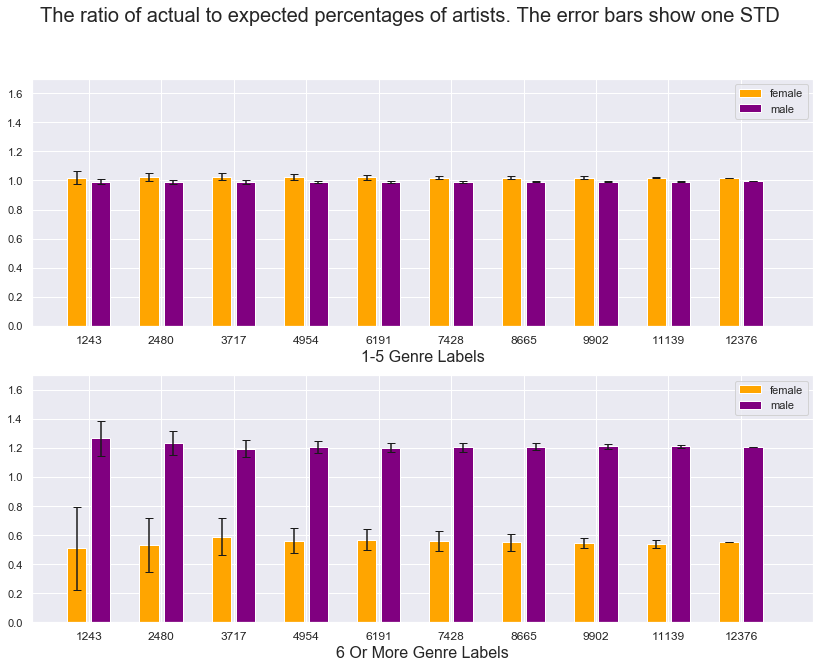

In [24]:
idx = pd.IndexSlice
df = biases
# extract lists of values for the means of each category
# flip arrays so that subset size increases left to right
df_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['fem mean']] ].values.flatten())
df_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['fem mean']] ].values.flatten())
df_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['mal mean']] ].values.flatten())
df_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['mal mean']] ].values.flatten())

# extract the stds
eb_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['fem std']] ].values.flatten())
eb_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['fem std']] ].values.flatten())
eb_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['mal std']] ].values.flatten())
eb_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['mal std']] ].values.flatten())

# indices for bars
number_of_bars = len(df_fem_small)
ind_fem = np.arange(0,3*number_of_bars,3)
ind_mal = np.arange(1,3*number_of_bars+1,3)
xlabel_pos = np.arange(0,3*number_of_bars+1,3)+.5

# set xticklabels; flip so order is small to large, as above
xticklabels = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)

fig, axs = plt.subplots(2,1, sharey = True, figsize = (14,10))
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar(ind_fem,df_fem_small, color = 'orange', yerr = eb_fem_small, capsize = 4, label = 'female')
axs[0].bar(ind_mal,df_mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')
axs[1].bar(ind_fem,df_fem_large, color = 'orange', yerr = eb_fem_large, capsize = 4, label = 'female')
axs[1].bar(ind_mal,df_mal_large, color = 'purple', yerr = eb_mal_large, capsize = 4, label = 'male')

# y range
axs[0].set_ylim(0,1.7)
axs[1].set_ylim(0,1.7)

# styles
axs[0].set_xticks(xlabel_pos)
axs[0].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[1].set_xticks(xlabel_pos)
axs[1].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[0].set_xlabel('1-5 genre labels'.title(), fontsize = 16)
axs[1].set_xlabel('6 or more genre labels'.title(), fontsize = 16)
axs[0].legend()
axs[1].legend()